### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [1]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt

from tqdm import tqdm

from typing import List
# __________end of block__________

In [2]:
# do not change the code in the block below
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cuda device is available


#### 1. Загрузка данных.

In [3]:
# do not change the code in the block below
# __________start of block__________
if not os.path.exists('onegin.txt'):
    !wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [4]:
# do not change the code in the block below
# __________start of block__________
SOS_TOKEN = '<sos>'
tokens = sorted(set(text.lower())) + [SOS_TOKEN]
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_index = {x: idx for idx, x in enumerate(tokens)}
index_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_index), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_index[x] for x in text]
# __________end of block__________

Seems fine!


In [5]:
text_indices = [token_to_index[token] for token in text]

__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [6]:
# do not change the code in the block below
# __________start of block__________
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_index['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________    

Пример батча:

In [7]:
next(generate_chunk())

array([[83, 68, 50, ..., 55, 64, 55],
       [83, 50,  1, ..., 59, 57,  1],
       [83, 60, 61, ...,  5,  1, 58],
       ...,
       [83, 61, 64, ..., 49, 50, 68],
       [83, 58, 72, ..., 56, 53, 81],
       [83, 44,  1, ..., 78,  1, 43]])

Далее вам предстоит написать код для обучения модели и генерации текста.

In [8]:
def get_random_chunk(batch_size, seq_length):
    text_len = len(text)
    # start_index in [0, text_len - seq_length - 1]
    start_indices = np.random.randint(low=0, high=text_len - seq_length, size=batch_size)
    random_chunks = [[token_to_index[SOS_TOKEN]] + text_indices[start_index:start_index + seq_length] for start_index in start_indices]
    random_chunks = np.array(random_chunks)
    assert random_chunks.shape == (batch_size, seq_length + 1)
    return random_chunks

In [9]:
def assert_check_shapes(lhs_shape, rhs_shape):
    assertion_message = f"Not equal shapes: {lhs_shape} instead of {rhs_shape}"
    assert lhs_shape == rhs_shape, assertion_message

In [10]:
class RNNCell(nn.Module):
    def __init__(self, num_tokens, embedding_size, hidden_embedding_size):
        super(self.__class__, self).__init__()
        self.num_tokens = num_tokens
        self.embedding_size = embedding_size
        self.hidden_embedding_size = hidden_embedding_size

        self.embedding_layer = nn.Embedding(num_embeddings=num_tokens, embedding_dim=embedding_size)

        # input shape:              (batch_size, 1)
        # with embeds shape:        (batch_size, embedding_size)
        # last hidden state shape:  (batch_size, hidden_embedding_size)
        self.W_to_new_hidden = nn.Linear(embedding_size + hidden_embedding_size, hidden_embedding_size)
        self.W_to_raw_logits = nn.Linear(hidden_embedding_size, num_tokens)

    def forward(self, input, last_hidden_state):
        batch_size = input.shape[0]

        # (batch, embedding_size)
        input_embeddings = self.embedding_layer(input).squeeze(dim=1)
        assert_check_shapes(
            input_embeddings.shape, 
            (batch_size, self.embedding_size)
        )

        # (batch, embedding_size + hidden_embedding_size)
        concat_input_and_last_hidden = torch.cat([input_embeddings, last_hidden_state], dim=-1)
        assert_check_shapes(
            concat_input_and_last_hidden.shape, 
            (batch_size, self.embedding_size + self.hidden_embedding_size)
        )

        # (batch, hidden_embedding_size)
        new_hidden_state = self.W_to_new_hidden(concat_input_and_last_hidden)
        assert_check_shapes(
            new_hidden_state.shape, (batch_size, self.hidden_embedding_size)
        )

        # (batch, num_tokens)
        raw_logits = self.W_to_raw_logits(new_hidden_state)
        assert_check_shapes(
            raw_logits.shape, 
            (batch_size, self.num_tokens)
        )

        return {
            'raw_logits' : raw_logits,
            'hidden_state' : new_hidden_state
        }
    
    def get_start_state(self, batch_size):
        return torch.zeros(batch_size, self.hidden_embedding_size, requires_grad=True)

In [11]:
def rnn_loop(rnn_cell, batch_indices):
    batch_size = batch_indices.shape[0]
    seq_length = batch_indices.shape[1] - 1
    
    last_hidden_state = rnn_cell.get_start_state(batch_size)
    
    all_logits = []
    true_tokens = []

    for i in range(0, seq_length + 1):
        input = torch.LongTensor(batch_indices[:, i]).unsqueeze(dim=-1)
        assert input.shape == (batch_size, 1)
        output = rnn_cell(input, last_hidden_state)
        
        all_logits.append(output['raw_logits'])
        true_tokens.append(input)

        last_hidden_state = output['hidden_state']

    stacked_logits = torch.stack(all_logits, dim=1)
    assert_check_shapes(
        stacked_logits.shape, 
        (batch_size, seq_length + 1, num_tokens)
    )

    stacked_true_tokens = torch.stack(true_tokens, dim=-1).squeeze(dim=1)
    assert_check_shapes(
        stacked_true_tokens.shape,
        (batch_size, seq_length + 1)
    )
    
    return {
        'stacked_logits' : stacked_logits,
        'true_tokens' : stacked_true_tokens
    }

В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

In [12]:
def train(
    num_tokens, 
    seq_length,
    embedding_size, 
    hidden_embedding_size, 
    batch_size=8,
    epochs=1000
):
    rnn_cell = RNNCell(
        num_tokens=num_tokens,
        embedding_size=embedding_size,
        hidden_embedding_size=hidden_embedding_size
    )

    loss_func = nn.CrossEntropyLoss()
    optimizer = opt = torch.optim.Adam(rnn_cell.parameters())

    loss_history = []
    
    for epoch in tqdm(range(epochs), desc='Iterating batches...'):
        opt.zero_grad()
        batch_indices = get_random_chunk(seq_length=seq_length, batch_size=batch_size)
        output = rnn_loop(rnn_cell=rnn_cell, batch_indices=batch_indices)

        stacked_logits = output['stacked_logits']
        true_tokens = output['true_tokens']

        stacked_logits_flat = torch.flatten(stacked_logits[:, :-1, :], end_dim=1)
    
        actual_next_tokens = torch.LongTensor(batch_indices[:, 1:].flatten())
        
        # print("------")
        # print("batch_indices: ", batch_indices.shape)
        # print("stacked_logits: ", stacked_logits.shape)
        # print("actual_next_tokens: ", actual_next_tokens.shape)
        # print("------")

        # break

        loss = loss_func(stacked_logits_flat, actual_next_tokens)

        loss.backward()
        optimizer.step()

        if (epoch + 1) % 1 == 0:
            loss_history.append(loss.data)
            
    plt.plot(loss_history, label="loss")
    plt.legend()
    plt.show()
            
    return rnn_cell

In [13]:
embedding_size = 32
hidden_embedding_size = 64
batch_size = 8
seq_length = 128
assert num_tokens == len(tokens)

Iterating batches...: 100%|██████████| 3000/3000 [01:21<00:00, 36.71it/s]


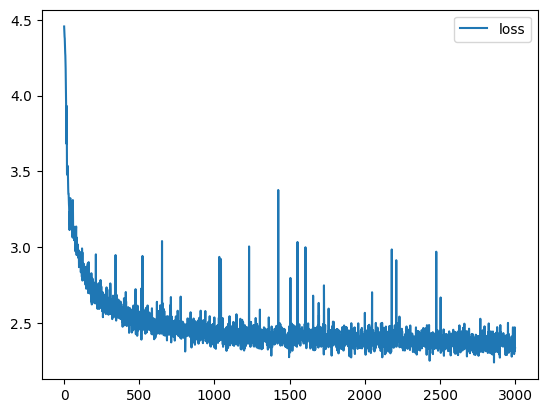

In [14]:
trained_rnn_cell = train(
    num_tokens=num_tokens,
    seq_length=seq_length,
    embedding_size=embedding_size,
    hidden_embedding_size=hidden_embedding_size,
    batch_size=batch_size,
    epochs=3000
)

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [15]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else: 
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    
    #feed the seed phrase, if any
            
    # your code here
    
    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

In [22]:
@torch.inference_mode()
def generate(
    start_text: List[str], 
    rnn_cell: RNNCell,
    max_length=100, 
    temperature=1.0
):
    zero_state = rnn_cell.get_start_state(batch_size=1)
    last_output = {
        'raw_logits' : None,
        'hidden_state' : zero_state
    }

    start_indices = [token_to_index[x] for x in start_text]

    for token_index in start_indices:
        input = torch.LongTensor([token_index])

        # print("input: ", input)
        # print("last_hidden_state: ", last_hidden_state)

        output = rnn_cell(input, last_output['hidden_state'])
        last_output = output

    text_gen = []
    for i in range(max_length - len(start_text)):
        next_token_probas = F.softmax(last_output['raw_logits'] / temperature, dim=-1).squeeze(dim=0)
        next_token_index = np.random.choice(num_tokens, p=next_token_probas.cpu().detach().numpy())

        text_gen.append(index_to_token[next_token_index])

        input = torch.LongTensor([next_token_index])
        output = rnn_cell(input, last_output['hidden_state'])
        last_output = output

    return "".join(start_text) + "".join(text_gen)

Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [23]:
# print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

In [24]:
START_TEXT = [x for x in ' мой дядя самых честных правил']

print(START_TEXT)

[' ', 'м', 'о', 'й', ' ', 'д', 'я', 'д', 'я', ' ', 'с', 'а', 'м', 'ы', 'х', ' ', 'ч', 'е', 'с', 'т', 'н', 'ы', 'х', ' ', 'п', 'р', 'а', 'в', 'и', 'л']


### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [25]:
seed_phrase = ' мой дядя самых честных правил'

In [26]:
# generated_phrases = # your code here

# For example:

generated_phrases = [
    generate(
        START_TEXT,
        trained_rnn_cell,
        max_length=500,
        temperature=1.
    ).replace('<sos>', '')
    for _ in range(10)
]

In [30]:
# do not change the code in the block below
# __________start of block__________

import json
if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'
    

submission_dict = {
    'token_to_idx': token_to_index,
    'generated_phrases': generated_phrases
}

with open('data/submission_dict.json', 'w') as iofile:
    json.dump(submission_dict, iofile, ensure_ascii=False, indent=4)
print('File saved to `submission_dict.json`')
# __________end of block__________

File saved to `submission_dict.json`


На этом задание завершено. Поздравляем!